In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings
# Menyembunyikan semua peringatan
warnings.filterwarnings('ignore')


# Read Data

In [2]:
# Memuat dataset
df = pd.read_csv('restaurant_menu_optimization_data.csv')

In [3]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RestaurantID   1000 non-null   object 
 1   MenuCategory   1000 non-null   object 
 2   MenuItem       1000 non-null   object 
 3   Ingredients    1000 non-null   object 
 4   Price          1000 non-null   float64
 5   Profitability  1000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


In [4]:
# Display first few rows
df.head()


,RestaurantID,MenuCategory,MenuItem,Ingredients,Price,Profitability
0,R003,Beverages,Soda,['confidential'],2.55,Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",11.12,Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",18.66,High
3,R003,Main Course,Chicken Alfredo,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",29.55,High
4,R002,Main Course,Grilled Steak,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",17.73,Medium


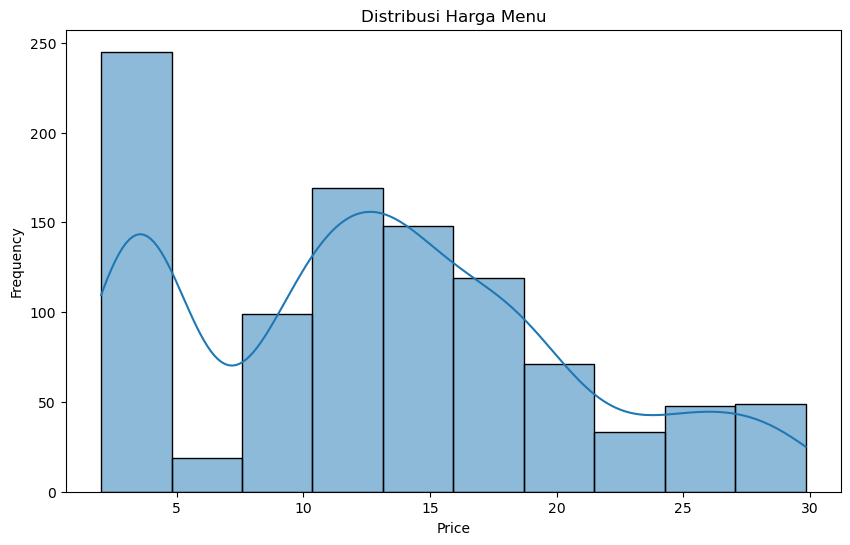

In [5]:
# Visualisasi distribusi harga
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=10, kde=True)
plt.title('Distribusi Harga Menu')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


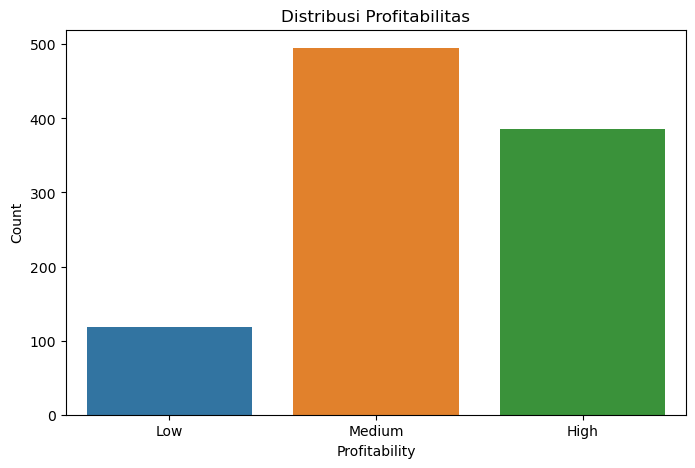

In [6]:
# Visualisasi profitabilitas
plt.figure(figsize=(8, 5))
sns.countplot(x='Profitability', data=df)
plt.title('Distribusi Profitabilitas')
plt.xlabel('Profitability')
plt.ylabel('Count')
plt.show()

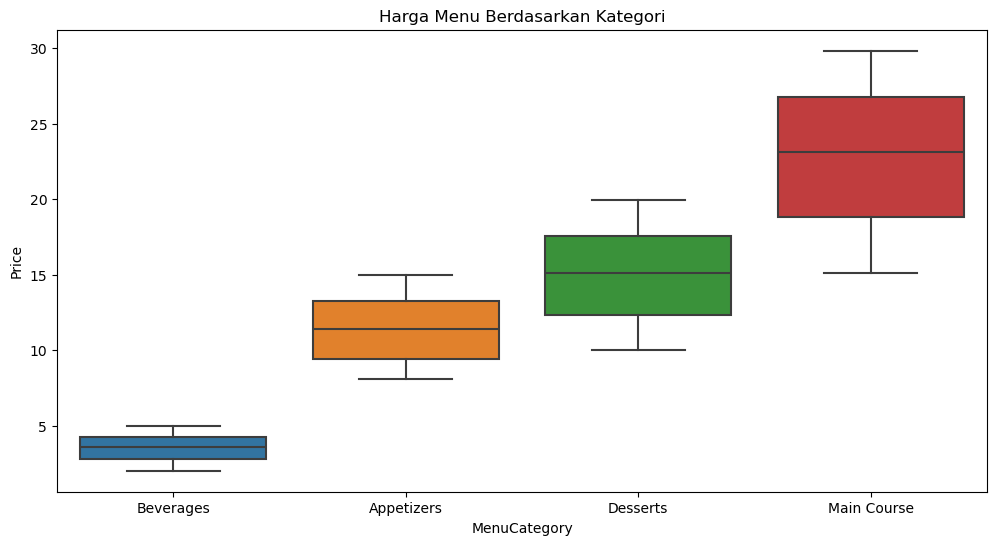

In [7]:
# Visualisasi harga berdasarkan kategori menu
plt.figure(figsize=(12, 6))
sns.boxplot(x='MenuCategory', y='Price', data=df)
plt.title('Harga Menu Berdasarkan Kategori')
plt.xlabel('MenuCategory')
plt.ylabel('Price')
plt.show()

# Stage 2: Data Preprocessing

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Definisi DataFrame dan pemilihan kolom
df_select = df[['MenuCategory', 'MenuItem','Price', 'Profitability']]

In [9]:
# Separate
train_df = df_select.iloc[:978, :]
test_df = df_select.iloc[978:,:]

print("Train data size:", train_df.shape)
print("Test data size:", test_df.shape)

Train data size: (978, 4)
Test data size: (22, 4)


In [10]:
# Cek missing values
print("Missing values:\n", df_select.isnull().sum())

Missing values:
 MenuCategory     0
MenuItem         0
Price            0
Profitability    0
dtype: int64


In [11]:
# Pisahkan fitur (x) dan target (y)
x = train_df.drop(columns='Profitability', axis=1)
y = train_df['Profitability']

In [12]:
# Split data menjadi data latih dan data uji
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1234, test_size=0.2)

In [13]:
# Inisialisasi ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ("cat_menu_category", OneHotEncoder(drop='first'), ['MenuCategory']),
        ("cat_menu_item", CountVectorizer(), 'MenuItem'),
        ("num_price", MinMaxScaler(), ['Price'])
    ],
    remainder='passthrough'
)

In [14]:
# Transformasi data
x_train_trans = ct.fit_transform(x_train)
x_test_trans = ct.transform(x_test)

In [15]:
# Memeriksa hasil
print(x_train_trans.shape)
print(x_test_trans.shape)

(782, 35)
(196, 35)


# Stage 3: Model Training and Comparison

# Model Random Forest

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

In [17]:
# Example for Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('classifier', RandomForestClassifier())
])
rf_pipeline.fit(x_train, y_train)
y_pred_rf = rf_pipeline.predict(x_test)

In [18]:
# Evaluasi
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest - Akurasi: {accuracy_rf:.4f}")
print(f"Random Forest - Presisi: {precision_rf:.4f}")
print(f"Random Forest - Recall: {recall_rf:.4f}")
print(f"Random Forest - Nilai F1: {f1_rf:.4f}")

Random Forest - Akurasi: 0.8724
Random Forest - Presisi: 0.8840
Random Forest - Recall: 0.8724
Random Forest - Nilai F1: 0.8762


In [19]:
# Print classification report
print("Random Forest - Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest - Classification Report:
               precision    recall  f1-score   support

        High       0.85      0.90      0.87        67
         Low       0.60      0.75      0.67        20
      Medium       0.96      0.88      0.92       109

    accuracy                           0.87       196
   macro avg       0.80      0.84      0.82       196
weighted avg       0.88      0.87      0.88       196



In [20]:
# Cross-Validation
cv_scores_rf = cross_val_score(rf_pipeline, x_train, y_train, cv=5)
print(f"Random Forest Cross-Validation Score: {cv_scores_rf.mean():.4f}")

Random Forest Cross-Validation Score: 0.8466


# Model KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# Inisialisasi Pipeline untuk KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', ct),                 # Preprocessing dengan ColumnTransformer
    ('classifier', KNeighborsClassifier())    # KNN classifier
])

# Train KNN model
knn_pipeline.fit(x_train, y_train)

# Prediksi dengan model yang sudah dilatih
y_pred_knn = knn_pipeline.predict(x_test)

In [22]:
# Evaluasi
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f"KNN - Akurasi: {accuracy_knn:.4f}")
print(f"KNN - Presisi: {precision_knn:.4f}")
print(f"KNN - Recall: {recall_knn:.4f}")
print(f"KNN - Nilai F1: {f1_knn:.4f}")

KNN - Akurasi: 0.9286
KNN - Presisi: 0.9331
KNN - Recall: 0.9286
KNN - Nilai F1: 0.9277


In [23]:
# Print classification report
print("KNN - Classification Report:\n", classification_report(y_test, y_pred_knn))

KNN - Classification Report:
               precision    recall  f1-score   support

        High       0.86      0.97      0.91        67
         Low       0.93      0.70      0.80        20
      Medium       0.98      0.94      0.96       109

    accuracy                           0.93       196
   macro avg       0.92      0.87      0.89       196
weighted avg       0.93      0.93      0.93       196



In [24]:
# Cross-Validation untuk KNN
cv_scores_knn = cross_val_score(knn_pipeline, x_train, y_train, cv=5)
print(f"KNN Cross-Validation Score: {cv_scores_knn.mean():.4f}")

KNN Cross-Validation Score: 0.9041


In [25]:
# Simpan model jika diperlukan
import pickle
with open('restaurant_model.sav', 'wb') as file:
    pickle.dump(knn_pipeline, file)

# Model ANN

In [26]:
from sklearn.neural_network import MLPClassifier

# Inisialisasi Pipeline untuk ANN
ann_pipeline = Pipeline(steps=[
    ('preprocessor', ct),  # Preprocessing dengan ColumnTransformer
    ('classifier', MLPClassifier(max_iter=500))  # ANN classifier
])

# Train ANN model
ann_pipeline.fit(x_train, y_train)

# Prediksi dengan model yang sudah dilatih
y_pred_ann = ann_pipeline.predict(x_test)

In [27]:
# Evaluasi
accuracy_ann = accuracy_score(y_test, y_pred_ann)
precision_ann = precision_score(y_test, y_pred_ann, average='weighted')
recall_ann = recall_score(y_test, y_pred_ann, average='weighted')
f1_ann = f1_score(y_test, y_pred_ann, average='weighted')

print(f"ANN - Akurasi: {accuracy_ann:.4f}")
print(f"ANN - Presisi: {precision_ann:.4f}")
print(f"ANN - Recall: {recall_ann:.4f}")
print(f"ANN - Nilai F1: {f1_ann:.4f}")


ANN - Akurasi: 0.9133
ANN - Presisi: 0.9175
ANN - Recall: 0.9133
ANN - Nilai F1: 0.9126


In [28]:
# Print classification report
print("ANN - Classification Report:\n", classification_report(y_test, y_pred_ann))

ANN - Classification Report:
               precision    recall  f1-score   support

        High       0.84      0.94      0.89        67
         Low       0.93      0.70      0.80        20
      Medium       0.96      0.94      0.95       109

    accuracy                           0.91       196
   macro avg       0.91      0.86      0.88       196
weighted avg       0.92      0.91      0.91       196



In [29]:
# Cross-Validation untuk ANN
cv_scores_ann = cross_val_score(ann_pipeline, x_train, y_train, cv=5)
print(f"ANN Cross-Validation Score: {cv_scores_ann.mean():.4f}")

ANN Cross-Validation Score: 0.8376


# Membandingkan Kinerja Model

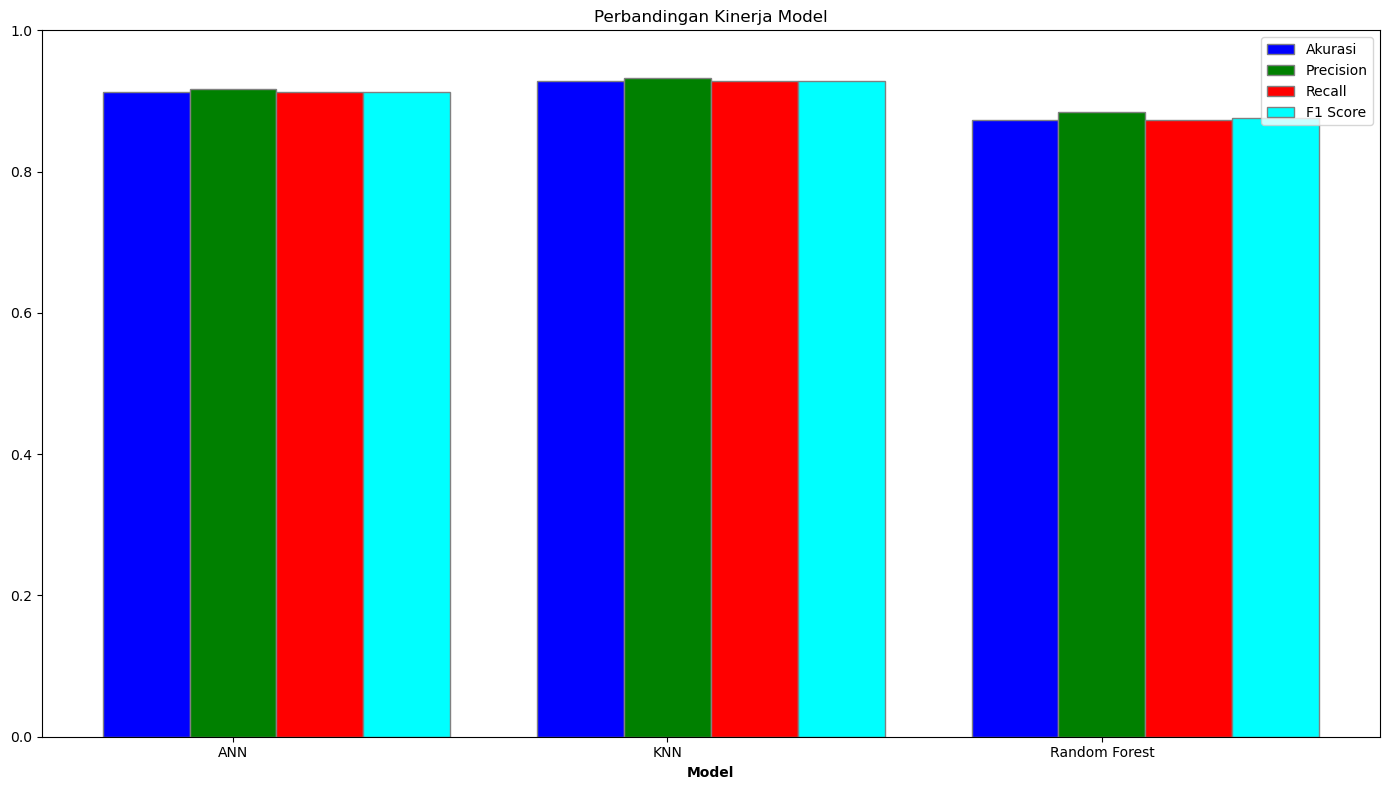

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Data untuk visualisasi
models = ['ANN', 'KNN', 'Random Forest']
accuracies = [accuracy_ann, accuracy_knn, accuracy_rf]
f1_scores = [f1_ann, f1_knn, f1_rf]
precisions = [precision_ann, precision_knn, precision_rf]
recalls = [recall_ann, recall_knn, recall_rf]

# Bar width
bar_width = 0.2

# Posisi untuk bar
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Ukuran figure
plt.figure(figsize=(14, 8))

# Membuat bar untuk masing-masing metrik
plt.bar(r1, accuracies, color='blue', width=bar_width, edgecolor='grey', label='Akurasi')
plt.bar(r2, precisions, color='green', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, recalls, color='red', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, f1_scores, color='cyan', width=bar_width, edgecolor='grey', label='F1 Score')

# Menambahkan label ke sumbu x
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)

# Menambahkan judul dan legend
plt.title('Perbandingan Kinerja Model')
plt.ylim([0, 1])
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()




In [31]:
import pickle

In [32]:
filename ="restaurant_model.sav"
pickle.dump(knn_pipeline, open(filename, 'wb') )